## Similarity fn qualitative comparison

In [1]:
import os
#virtually move to parent directory
os.chdir("..")

import torch
import matplotlib
from matplotlib import pyplot as plt

import utils
import data_utils
import similarity
from experiments import text_colorings

## Settings

In [2]:
figure = 'fig14b'

settings = {'fig14a': {"target_name":'resnet50', "target_layer": 'layer1', "neurons_to_display": [46, 10, 242, 206]}, 
            'fig14b': {"target_name":'resnet50', "target_layer": 'layer4', "neurons_to_display": [1203, 1731, 683, 185]},
           }

target_name = settings[figure]["target_name"]
target_layer = settings[figure]["target_layer"]
neurons_to_display = settings[figure]["neurons_to_display"]

clip_name = 'ViT-B/16'
d_probe = 'imagenet_broden'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'


## Run CLIP-Dissect

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

In [4]:
similarity_fn = similarity.cos_similarity
similarities_cos, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity.cos_similarity, device=device)

similarities_soft_wpmi, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity.soft_wpmi, device=device)

100%|██████████| 2048/2048 [00:14<00:00, 142.58it/s]


torch.Size([2048, 20000])


## Visualize

In [5]:
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

get_color = text_colorings.get_coloring(figure)

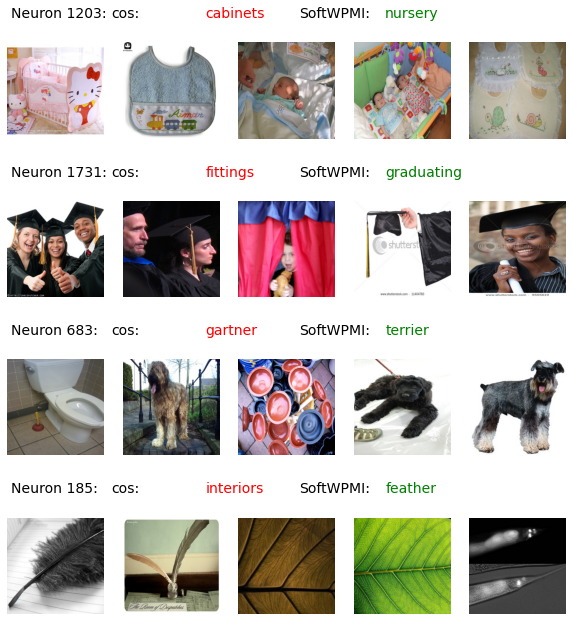

In [6]:
# Calculate which neurons to show
if type(neurons_to_display)==list:
    ids_to_check = neurons_to_display
if neurons_to_display == "CLIP-Dissect":
    ids_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
elif neurons_to_display == "NetDissect":
    ids_to_check = torch.sort(torch.tensor(nd_ious), descending=True)[1][:10]

    
#plot figures
font_size=14
font = {'size' : font_size}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(ids_to_check)*2.2])
subfigs = fig.subfigures(nrows=len(ids_to_check), ncols=1)
for j, orig_id in enumerate(ids_to_check):
    _, cos_ids = torch.topk(similarities_cos[orig_id], k=5, largest=True)
    _, soft_wpmi_ids = torch.topk(similarities_soft_wpmi[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "cos:", size=font_size)
    subfig.text(0.4, 0.96, words[int(cos_ids[0])], size=font_size, color=get_color("cos", j))
    subfig.text(0.53 ,0.96, "SoftWPMI:", size=font_size)
    subfig.text(0.65 ,0.96, words[int(soft_wpmi_ids[0])], size=font_size, color=get_color("soft_wpmi", j))
    
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
    #fig.tight_layout()
plt.show()